In [1]:
%load_ext autoreload
%autoreload 2

import os, ujson, shapely
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np

In [16]:
from bokeh.plotting import output_notebook, show
from mapvis import plot_gps, plot_wktlinestr

output_notebook()

Loading BokehJS ...

In [3]:
city = "chengdu"
osmap_dir = f"../data/osmap/{city}"
trips_dir = f"../data/trips/{city}"

Loading map data from shapefile downloaded from OpenStreetMap

In [4]:
nodes = gpd.read_file(os.path.join(osmap_dir, "nodes.shp"))
edges = gpd.read_file(os.path.join(osmap_dir, "edges.shp"))
nodes.set_index('osmid', inplace=True)
edges.set_index(['u', 'v', 'key'], inplace=True)

In [5]:
# run the code to see its structure
edges.head(3)

osmid       highway oneway   length   name  \
u         v          key                                                   
288416374 1815728532 0     28623889  unclassified  False   20.517   None   
          3541376393 0    137133120       primary   True  143.316  昭觉寺南路   
          314655436  0     28623889  unclassified  False  173.857   None   

                         lanes bridge   ref junction maxspeed tunnel  fid  \
u         v          key                                                    
288416374 1815728532 0    None   None  None     None     None   None    0   
          3541376393 0    None   None  None     None     None   None    1   
          314655436  0    None   None  None     None     None   None    2   

                                                                   geometry  
u         v          key                                                     
288416374 1815728532 0    LINESTRING (104.10029 30.71479, 104.10010 30.7...  
          3541376393 0    LINESTRING (104.10029 30.71479, 104.10079 30.7...  
          314655436  0    LINESTRING (104.10029 30.71479, 104.10160 30.7...

Constructing the road network (a directed multi-graph) from `nodes` and `edges`.

In [27]:
G = ox.graph_from_gdfs(nodes, edges)
print(type(G))
print(f'#nodes: {G.number_of_nodes()}, #edges: {G.number_of_edges()}')

<class 'networkx.classes.multidigraph.MultiDiGraph'>
#nodes: 2860, #edges: 6626


Checking the meta data associated to an edge, note that an edge in the MultiDiGraph is identified by a tuple `(u, v, key)`.

`fid` is the unique id of graph edge, it corresponds to the road segment id of road network.

In [7]:
G.edges[288416374, 314655436, 0]

{'osmid': '28623889',
 'highway': 'unclassified',
 'oneway': 'False',
 'length': 173.857,
 'fid': 2,
 'geometry': <LINESTRING (104.1 30.715, 104.102 30.714, 104.102 30.714, 104.102 30.714, 1...>}

Visualizing the graph with osmnx, in which the red color indicates the nodes.

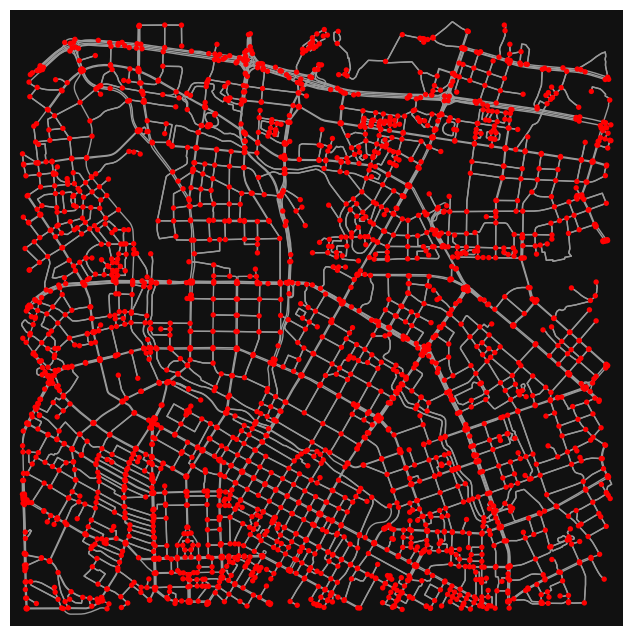

In [8]:
fig, ax = ox.plot_graph(G, node_color='r')

In [9]:
#fig, ax = ox.plot_graph(ox.simplify_graph(G), node_color='r')

Loading the trips.

In [10]:
trips_files = sorted([x for x in os.listdir(trips_dir) if x.endswith(".json")])
trips_file = trips_files[0]
print(f'Loading trips from {trips_file}...')

with open(os.path.join(trips_dir, trips_file)) as f:
    trips = ujson.load(f)

print(f'There are {len(trips)} trips in trips_file.')

Loading trips from gps_20161101.json...
There are 180860 trips in trips_file.


Checking the trip structure.

In [11]:
trip = trips[129197]
trip.keys()

dict_keys(['validspeed', 'cpath', 'state', 'mgeom', 'pgeom', 'ratio', 'tms', 'lon', 'index', 'devid', 'opath', 'spdist', 'lat'])

`cpath` is the matched road segment sequence of the trajectory.

In [12]:
print(trip['cpath'])

[4098, 3143, 3139, 5950, 5948, 623, 4848, 4853, 4844, 4846, 719, 170, 716, 714, 6545, 2667, 5777, 5782, 4806, 3015, 3038, 5865, 3033, 2954, 4823, 4819, 2929, 2907, 5695, 5698, 607, 6211, 5694, 5701, 5700, 5707, 5710, 5712, 5714, 5703, 5716, 5719, 5720, 5723, 4983, 4985, 4987, 4980, 429, 2261, 4359, 339, 6408, 1994, 5603, 6413, 6414, 5604, 5601, 5598, 5595, 5594, 2412, 5591, 5587, 1989]


Visualizing the trip and trajectory.

Plot the original trajectory.

In [42]:
show(plot_gps(trip['lon'][::3], trip['lat'][::3], 1.2))

Plot the matched geometry curve (specified by the road segment end points).

In [14]:
show(plot_wktlinestr(trip['mgeom']))

<Axes: >

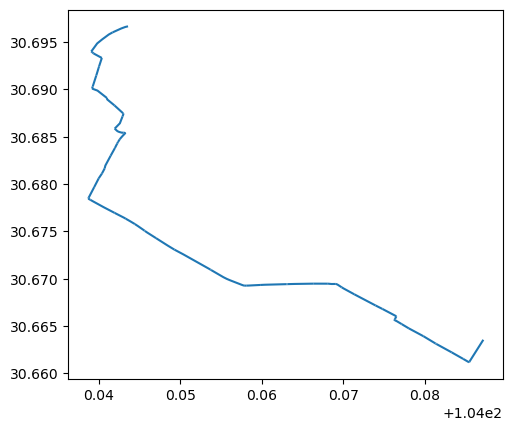

In [15]:
edges[edges.fid.isin(trip['cpath'])].plot()

In [31]:
lG = nx.line_graph(G)
print(type(lG))
print(f'#nodes: {lG.number_of_nodes()}, #edges: {lG.number_of_edges()}')

<class 'networkx.classes.multidigraph.MultiDiGraph'>
#nodes: 6626, #edges: 17173
